# Introduction to SimpleITKv4 Registration - Continued


## ITK v4 Registration Components 
<img src="ITKv4RegistrationComponentsDiagram.svg" style="width:700px"/><br><br>


Before starting with this notebook, please go over the first introductory notebook found [here](60_Registration_Introduction.ipynb). 

In this notebook we will visually assess registration by viewing the overlap between images using external viewers.
The two viewers we recommend for this task are [ITK-SNAP](http://www.itksnap.org) and [3D Slicer](http://www.slicer.org/). ITK-SNAP supports concurrent linked viewing between multiple instances of the program. 3D Slicer supports concurrent viewing of multiple volumes via alpha blending.

In [1]:
import SimpleITK as sitk

# If the environment variable SIMPLE_ITK_MEMORY_CONSTRAINED_ENVIRONMENT is set, this will override the ReadImage
# function so that it also resamples the image to a smaller size (testing environment is memory constrained).
%run setup_for_testing

# Utility method that either downloads data from the network or
# if already downloaded returns the file name for reading from disk (cached data).
%run update_path_to_download_script
from downloaddata import fetch_data as fdata

# Always write output to a separate directory, we don't want to pollute the source directory.
import os

OUTPUT_DIR = "Output"

# GUI components (sliders, dropdown...).
from ipywidgets import interact, fixed

# Enable display of HTML.
from IPython.display import display, HTML

# Plots will be inlined.
%matplotlib inline

# Callbacks for plotting registration progress.
import registration_callbacks

## Utility functions
A number of utility functions, saving a transform and corresponding resampled image, callback for selecting a 
DICOM series from several series found in the same directory.

In [8]:
def save_transform_and_image(transform, fixed_image, moving_image, outputfile_prefix):
    """
    Write the given transformation to file, resample the moving_image onto the fixed_images grid and save the
    result to file.

    Args:
        transform (SimpleITK Transform): transform that maps points from the fixed image coordinate system to the moving.
        fixed_image (SimpleITK Image): resample onto the spatial grid defined by this image.
        moving_image (SimpleITK Image): resample this image.
        outputfile_prefix (string): transform is written to outputfile_prefix.tfm and resampled image is written to
                                    outputfile_prefix.mha.
    """
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(fixed_image)

    # SimpleITK supports several interpolation options, we go with the simplest that gives reasonable results.
    resample.SetInterpolator(sitk.sitkLinear)
    resample.SetTransform(transform)
    sitk.WriteImage(resample.Execute(moving_image), outputfile_prefix + ".mha")
    sitk.WriteTransform(transform, outputfile_prefix + ".tfm")


def DICOM_series_dropdown_callback(fixed_image, moving_image, series_dictionary):
    """
    Callback from dropbox which selects the two series which will be used for registration.
    The callback prints out some information about each of the series from the meta-data dictionary.
    For a list of all meta-dictionary tags and their human readable names see DICOM standard part 6,
    Data Dictionary (http://medical.nema.org/medical/dicom/current/output/pdf/part06.pdf)
    """
    # The callback will update these global variables with the user selection.
    global selected_series_fixed
    global selected_series_moving

    img_fixed = sitk.ReadImage(series_dictionary[fixed_image][0])
    img_moving = sitk.ReadImage(series_dictionary[moving_image][0])

    # There are many interesting tags in the DICOM data dictionary, display a selected few.
    tags_to_print = {
        "0010|0010": "Patient name: ",
        "0008|0060": "Modality: ",
        "0008|0021": "Series date: ",
        "0008|0031": "Series time:",
        "0008|0070": "Manufacturer: ",
    }
    html_table = []
    html_table.append(
        "<table><tr><td><b>Tag</b></td><td><b>Fixed Image</b></td><td><b>Moving Image</b></td></tr>"
    )
    for tag in tags_to_print:
        fixed_tag = ""
        moving_tag = ""
        try:
            fixed_tag = img_fixed.GetMetaData(tag)
        except:  # ignore if the tag isn't in the dictionary
            pass
        try:
            moving_tag = img_moving.GetMetaData(tag)
        except:  # ignore if the tag isn't in the dictionary
            pass
        html_table.append(
            "<tr><td>"
            + tags_to_print[tag]
            + "</td><td>"
            + fixed_tag
            + "</td><td>"
            + moving_tag
            + "</td></tr>"
        )
    html_table.append("</table>")
    display(HTML("".join(html_table)))
    selected_series_fixed = fixed_image
    selected_series_moving = moving_image

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import clear_output


# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1, 2, figsize=(10, 8))

    # Draw the fixed image in the first subplot.
    plt.subplot(1, 2, 1)
    plt.imshow(fixed_npa[fixed_image_z, :, :], cmap=plt.cm.Greys_r)
    plt.title("fixed image")
    plt.axis("off")

    # Draw the moving image in the second subplot.
    plt.subplot(1, 2, 2)
    plt.imshow(moving_npa[moving_image_z, :, :], cmap=plt.cm.Greys_r)
    plt.title("moving image")
    plt.axis("off")

    plt.show()


# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space.
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha) * fixed[:, :, image_z] + alpha * moving[:, :, image_z]
    plt.imshow(sitk.GetArrayViewFromImage(img), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.show()


# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations

    metric_values = []
    multires_iterations = []


# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations

    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()


# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations

    metric_values.append(registration_method.GetMetricValue())
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, "r")
    plt.plot(
        multires_iterations,
        [metric_values[index] for index in multires_iterations],
        "b*",
    )
    plt.xlabel("Iteration Number", fontsize=12)
    plt.ylabel("Metric Value", fontsize=12)
    plt.show()


# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the
# metric_values list.
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

## Loading Data

In this notebook we will work with CT and MR scans of the CIRS 057A multi-modality abdominal phantom. The scans are multi-slice DICOM images. The data is stored in a zip archive which is automatically retrieved and extracted when we request a file which is part of the archive.

In [3]:
data_directory = os.path.dirname(fdata("CIRS057A_MR_CT_DICOM/readme.txt"))

# 'selected_series_moving/fixed' will be updated by the interact function.
selected_series_fixed = ""
selected_series_moving = ""

# Directory contains multiple DICOM studies/series, store the file names
# in dictionary with the key being the series ID.
reader = sitk.ImageSeriesReader()
series_file_names = {}
series_IDs = list(reader.GetGDCMSeriesIDs(data_directory))  # list of all series

if series_IDs:  # check that we have at least one series
    for series in series_IDs:
        series_file_names[series] = reader.GetGDCMSeriesFileNames(
            data_directory, series
        )
    interact(
        DICOM_series_dropdown_callback,
        fixed_image=series_IDs,
        moving_image=series_IDs,
        series_dictionary=fixed(series_file_names),
    )
else:
    print("This is surprising, data directory does not contain any DICOM series.")

Fetching CIRS057A_MR_CT_DICOM/readme.txt


interactive(children=(Dropdown(description='fixed_image', options=('1.2.840.113619.2.290.3.3233817346.783.1399…

In [10]:
# Actually read the data based on the user's selection.
fixed_image = sitk.ReadImage(series_file_names[selected_series_fixed])
moving_image = sitk.ReadImage(series_file_names[selected_series_moving])

# Save images to file and view overlap using external viewer.
sitk.WriteImage(fixed_image, os.path.join(OUTPUT_DIR, "fixedImage.mha"))
sitk.WriteImage(moving_image, os.path.join(OUTPUT_DIR, "preAlignment.mha"))

interact(
    display_images,
    fixed_image_z=(0, fixed_image.GetSize()[2] - 1),
    moving_image_z=(0, moving_image.GetSize()[2] - 1),
    fixed_npa=fixed(sitk.GetArrayViewFromImage(fixed_image)),
    moving_npa=fixed(sitk.GetArrayViewFromImage(moving_image)),
);

interactive(children=(IntSlider(value=141, description='fixed_image_z', max=282), IntSlider(value=175, descrip…

## Initial Alignment

A reasonable guesstimate for the initial translational alignment can be obtained by using
the CenteredTransformInitializer (functional interface to the CenteredTransformInitializerFilter). 

The resulting transformation is centered with respect to the fixed image and the
translation aligns the centers of the two images. There are two options for
defining the centers of the images, either the physical centers
of the two data sets (GEOMETRY), or the centers defined by the intensity 
moments (MOMENTS).

Two things to note about this filter, it requires the fixed and moving image 
have the same type even though it is not algorithmically required, and its
return type is the generic SimpleITK.Transform.

In [13]:
initial_transform = sitk.CenteredTransformInitializer(
    sitk.Cast(fixed_image, moving_image.GetPixelID()),
    moving_image,
    sitk.Euler3DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)

# Save moving image after initial transform and view overlap using external viewer.
save_transform_and_image(
    initial_transform,
    fixed_image,
    moving_image,
    os.path.join(OUTPUT_DIR, "initialAlignment"),
)


Look at the transformation, what type is it?

In [6]:
print(initial_transform)

itk::simple::Transform
 Euler3DTransform (0000019B67B51C30)
   RTTI typeinfo:   class itk::Euler3DTransform<double>
   Reference Count: 1
   Modified Time: 27776
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     1 0 0 
     0 1 0 
     0 0 1 
   Offset: [20.0012, 29.0821, 83.8438]
   Center: [-0.328125, -0.328125, -106.875]
   Translation: [20.0012, 29.0821, 83.8438]
   Inverse: 
     1 0 0 
     0 1 0 
     0 0 1 
   Singular: 0
   Euler's angles: AngleX=0 AngleY=0 AngleZ=0
   m_ComputeZYX = 0



## Final registration

### Version 1
<ul>
<li> Single scale (not using image pyramid).</li>
<li> Initial transformation is not modified in place.</li>
</ul>

<ol>
<li>
Illustrate the need for scaling the step size differently for each parameter:
<ul>
<li> SetOptimizerScalesFromIndexShift - estimated from maximum shift of voxel indexes (only use if data is isotropic).</li>
<li> SetOptimizerScalesFromPhysicalShift - estimated from maximum shift of physical locations of voxels.</li>
<li> SetOptimizerScalesFromJacobian - estimated from the averaged squared norm of the Jacobian w.r.t. parameters.</li>
</ul>
</li>
<li>
Look at the optimizer's stopping condition to ensure we have not terminated prematurely.
</li>
</ol>

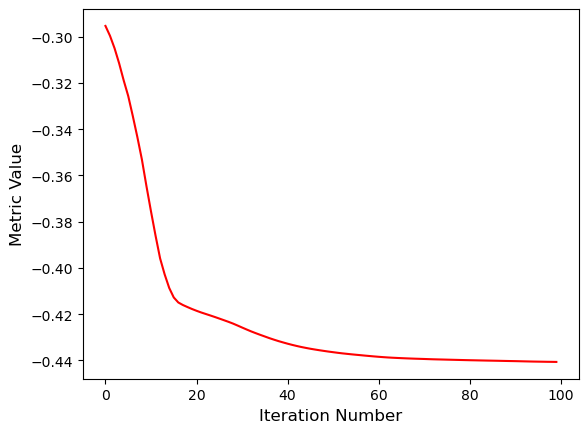

In [14]:
registration_method = sitk.ImageRegistrationMethod()

registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

# The learningRate parameter is always required. Using the default
# configuration this parameter is ignored because it is overridden
# by the default setting of the estimateLearningRate parameter which
# is sitk.ImageRegistrationMethod.Once. For the user selected
# learningRate to take effect you need to also set the
# estimateLearningRate parameter to sitk.ImageRegistrationMethod.Never
registration_method.SetOptimizerAsGradientDescent(
    learningRate=1.0, numberOfIterations=100
)
# Scale the step size differently for each parameter, this is critical!!!
registration_method.SetOptimizerScalesFromPhysicalShift()

registration_method.SetInitialTransform(initial_transform, inPlace=False)

registration_method.AddCommand(
    sitk.sitkStartEvent, registration_callbacks.metric_start_plot
)
registration_method.AddCommand(
    sitk.sitkEndEvent, registration_callbacks.metric_end_plot
)
registration_method.AddCommand(
    sitk.sitkIterationEvent,
    lambda: registration_callbacks.metric_plot_values(registration_method),
)

final_transform_v1 = registration_method.Execute(
    sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32)
)

In [15]:
print(
    f"Optimizer's stopping condition, {registration_method.GetOptimizerStopConditionDescription()}"
)
print(f"Final metric value: {registration_method.GetMetricValue()}")

# Save moving image after registration and view overlap using external viewer.
save_transform_and_image(
    final_transform_v1,
    fixed_image,
    moving_image,
    os.path.join(OUTPUT_DIR, "finalAlignment-v1"),
)

Optimizer's stopping condition, GradientDescentOptimizerv4Template: Maximum number of iterations (100) exceeded.
Final metric value: -0.4406701808490427


Look at the final transformation, what type is it?

In [16]:
print(final_transform_v1)

itk::simple::CompositeTransform
 CompositeTransform (0000019B721F1040)
   RTTI typeinfo:   class itk::CompositeTransform<double,3>
   Reference Count: 1
   Modified Time: 1552668
   Debug: Off
   Object Name: 
   Observers: 
     none
   Transforms in queue, from begin to end:
   >>>>>>>>>
   Euler3DTransform (0000019B7D05A9A0)
     RTTI typeinfo:   class itk::Euler3DTransform<double>
     Reference Count: 1
     Modified Time: 1552658
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       0.998665 0.0232615 -0.0461145 
       -0.0230107 0.999717 0.00596156 
       0.0462401 -0.00489248 0.998918 
     Offset: [11.558, 40.2789, 79.2492]
     Center: [-0.328125, -0.328125, -106.875]
     Translation: [16.4793, 39.6494, 79.3512]
     Inverse: 
       0.998665 -0.0230107 0.0462401 
       0.0232615 0.999717 -0.00489248 
       -0.0461145 0.00596156 0.998918 
     Singular: 0
     Euler's angles: AngleX=-0.0048925 AngleY=-0.0462572 AngleZ=-0.0232638
     m_Comp

### Version 1.1

The previous example illustrated the use of the ITK v4 registration framework in an ITK v3 manner. We only referred to a single transformation which was what we optimized.

In ITK v4 the registration method accepts three transformations (if you look at the diagram above you will only see two transformations, Moving transform represents $T_{opt} \circ T_m$):
<ul>
<li>
SetInitialTransform, $T_{opt}$ - composed with the moving initial transform, maps points from the virtual image domain to the moving image domain, modified during optimization. 
</li>
<li>
SetFixedInitialTransform $T_f$- maps points from the virtual image domain to the fixed image domain, never modified.
</li>
<li>
SetMovingInitialTransform $T_m$- maps points from the virtual image domain to the moving image domain, never modified.
</li>
</ul>

The transformation that maps points from the fixed to moving image domains is thus: $^M\mathbf{p}  = T_{opt}(T_m(T_f^{-1}(^F\mathbf{p})))$

We now modify the previous example to use $T_{opt}$ and $T_m$.

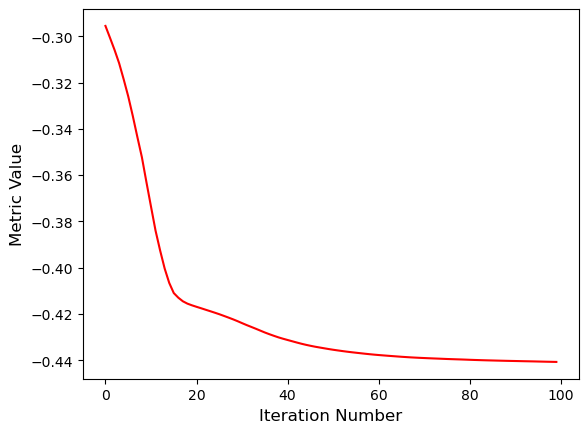

In [17]:
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsGradientDescent(
    learningRate=1.0, numberOfIterations=100
)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Set the initial moving and optimized transforms.
optimized_transform = sitk.Euler3DTransform()
registration_method.SetMovingInitialTransform(initial_transform)
registration_method.SetInitialTransform(optimized_transform)

registration_method.AddCommand(
    sitk.sitkStartEvent, registration_callbacks.metric_start_plot
)
registration_method.AddCommand(
    sitk.sitkEndEvent, registration_callbacks.metric_end_plot
)
registration_method.AddCommand(
    sitk.sitkIterationEvent,
    lambda: registration_callbacks.metric_plot_values(registration_method),
)

registration_method.Execute(
    sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32)
)

# Need to compose the transformations after registration.
final_transform_v11 = sitk.CompositeTransform(optimized_transform)
final_transform_v11.AddTransform(initial_transform)

In [18]:
print(
    f"Optimizer's stopping condition, {registration_method.GetOptimizerStopConditionDescription()}"
)
print(f"Final metric value: {registration_method.GetMetricValue()}")

# Save moving image after registration and view overlap using external viewer.
save_transform_and_image(
    final_transform_v11,
    fixed_image,
    moving_image,
    os.path.join(OUTPUT_DIR, "finalAlignment-v1.1"),
)

Optimizer's stopping condition, GradientDescentOptimizerv4Template: Maximum number of iterations (100) exceeded.
Final metric value: -0.44071483335887257


Look at the final transformation, what type is it? Why is it different from the previous example?

In [20]:
print(final_transform_v11)

itk::simple::CompositeTransform
 CompositeTransform (0000019B721F1810)
   RTTI typeinfo:   class itk::CompositeTransform<double,3>
   Reference Count: 1
   Modified Time: 3051967
   Debug: Off
   Object Name: 
   Observers: 
     none
   Transforms in queue, from begin to end:
   >>>>>>>>>
   Euler3DTransform (0000019B72B6DCE0)
     RTTI typeinfo:   class itk::Euler3DTransform<double>
     Reference Count: 3
     Modified Time: 3051943
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       0.998693 0.0246109 -0.0447878 
       -0.0242545 0.99967 0.0084835 
       0.0449818 -0.00738611 0.998961 
     Offset: [-8.26234, 11.6049, -4.69043]
     Center: [-0.328125, -0.328125, -106.875]
     Translation: [-3.48329, 10.7063, -4.59167]
     Inverse: 
       0.998693 -0.0242545 0.0449818 
       0.0246109 0.99967 -0.00738611 
       -0.0447878 0.0084835 0.998961 
     Singular: 0
     Euler's angles: AngleX=-0.00738618 AngleY=-0.0449982 AngleZ=-0.0246141
     m_Co

### Version 2

<ul>
<li> Multi scale - specify both scale, and how much to smooth with respect to original image.</li>
<li> Initial transformation modified in place, so in the end we have the same type of transformation in hand.</li>
</ul>

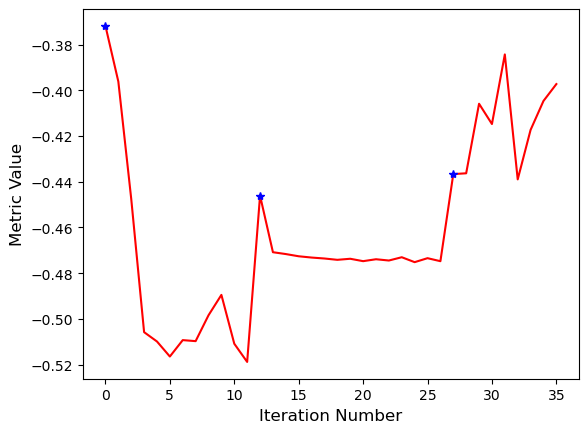

<SimpleITK.SimpleITK.Euler3DTransform; proxy of <Swig Object of type 'itk::simple::Euler3DTransform *' at 0x0000019B041C4D50> >

In [21]:
registration_method = sitk.ImageRegistrationMethod()

registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

registration_method.SetOptimizerAsGradientDescent(
    learningRate=1.0, numberOfIterations=100
)  # , estimateLearningRate=registration_method.EachIteration)
registration_method.SetOptimizerScalesFromPhysicalShift()

final_transform = sitk.Euler3DTransform(initial_transform)
registration_method.SetInitialTransform(final_transform)
registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

registration_method.AddCommand(
    sitk.sitkStartEvent, registration_callbacks.metric_start_plot
)
registration_method.AddCommand(
    sitk.sitkEndEvent, registration_callbacks.metric_end_plot
)
registration_method.AddCommand(
    sitk.sitkMultiResolutionIterationEvent,
    registration_callbacks.metric_update_multires_iterations,
)
registration_method.AddCommand(
    sitk.sitkIterationEvent,
    lambda: registration_callbacks.metric_plot_values(registration_method),
)

registration_method.Execute(
    sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32)
)

In [22]:
print(
    f"Optimizer's stopping condition, {registration_method.GetOptimizerStopConditionDescription()}"
)
print(f"Final metric value: {registration_method.GetMetricValue()}")

# Save moving image after registration and view overlap using external viewer.
save_transform_and_image(
    final_transform,
    fixed_image,
    moving_image,
    os.path.join(OUTPUT_DIR, "finalAlignment-v2"),
)

Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.
Final metric value: -0.42713087579058756


Look at the final transformation, what type is it?

In [23]:
print(final_transform)

itk::simple::Euler3DTransform
 Euler3DTransform (0000019B72B6DEF0)
   RTTI typeinfo:   class itk::Euler3DTransform<double>
   Reference Count: 3
   Modified Time: 4748587
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.998551 0.0279519 -0.0459765 
     -0.027676 0.999595 0.00662652 
     0.0461432 -0.00534448 0.998921 
   Offset: [12.7204, 42.1371, 79.1585]
   Center: [-0.328125, -0.328125, -106.875]
   Translation: [17.6255, 41.4381, 79.2605]
   Inverse: 
     0.998551 -0.027676 0.0461432 
     0.0279519 0.999595 -0.00534448 
     -0.0459765 0.00662652 0.998921 
   Singular: 0
   Euler's angles: AngleX=-0.0053445 AngleY=-0.0461602 AngleZ=-0.0279559
   m_ComputeZYX = 0

